In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from haversine import haversine, Unit

import sys 
sys.path.append('..')
from utils import dataloader

/opt/homebrew/Caskroom/miniforge/base/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dist_matrix = pd.read_csv('../data/distance_matrix.csv')
dist_matrix.head()
df = dataloader.load_data()

In [3]:
def get_graph(data, adjecency_threshold_km=3):
    G = nx.Graph()

    for cluster in data['Cluster'].unique():
        G.add_node(cluster)
        G.nodes[cluster]['ID'] = dist_matrix.columns.get_loc('WEBSTER')
        G.nodes[cluster]['lat'] = df[df['Cluster'] == cluster]['Latitude'].mean()
        G.nodes[cluster]['long'] = df[df['Cluster'] == cluster]['Longitude'].mean()
        G.nodes[cluster]['pos'] = (G.nodes[cluster]['long'], G.nodes[cluster]['lat'])


    for node_x in G.nodes:
        for node_y in G.nodes:
            dist = haversine(
                (G.nodes[node_x]['lat'], G.nodes[node_x]['long']),
                (G.nodes[node_y]['lat'], G.nodes[node_y]['long']),
                unit=Unit.KILOMETERS)
            if (dist > adjecency_threshold_km):
                continue
            G.add_edge(node_x, node_y)
            G[node_x][node_y]['weight'] = np.exp(-dist)


    adj = nx.adjacency_matrix(G)
    return G, adj.todense()
    #return G, normalize_adj(adj).todense()

In [4]:
G, adj = get_graph(df)
adj

array([[1.        , 0.7601335 , 0.75085098, 0.        , 0.15121136,
        0.626752  , 0.10122774, 0.09136573, 0.08287783],
       [0.7601335 , 1.        , 0.69668428, 0.        , 0.11736681,
        0.49617346, 0.09447831, 0.08807472, 0.07804632],
       [0.75085098, 0.69668428, 1.        , 0.        , 0.12715043,
        0.66410796, 0.07601352, 0.06867823, 0.06222899],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.06047852, 0.05383427, 0.06743359],
       [0.15121136, 0.11736681, 0.12715043, 0.        , 1.        ,
        0.17685044, 0.14195376, 0.10731153, 0.11823091],
       [0.626752  , 0.49617346, 0.66410796, 0.        , 0.17685044,
        1.        , 0.07846953, 0.06796571, 0.06370509],
       [0.10122774, 0.09447831, 0.07601352, 0.06047852, 0.14195376,
        0.07846953, 1.        , 0.74290641, 0.8089779 ],
       [0.09136573, 0.08807472, 0.06867823, 0.05383427, 0.10731153,
        0.06796571, 0.74290641, 1.        , 0.78672611],


In [5]:
df[df['Cluster'] == 'WEBSTER']['Longitude'].mean()

-122.15817534247704

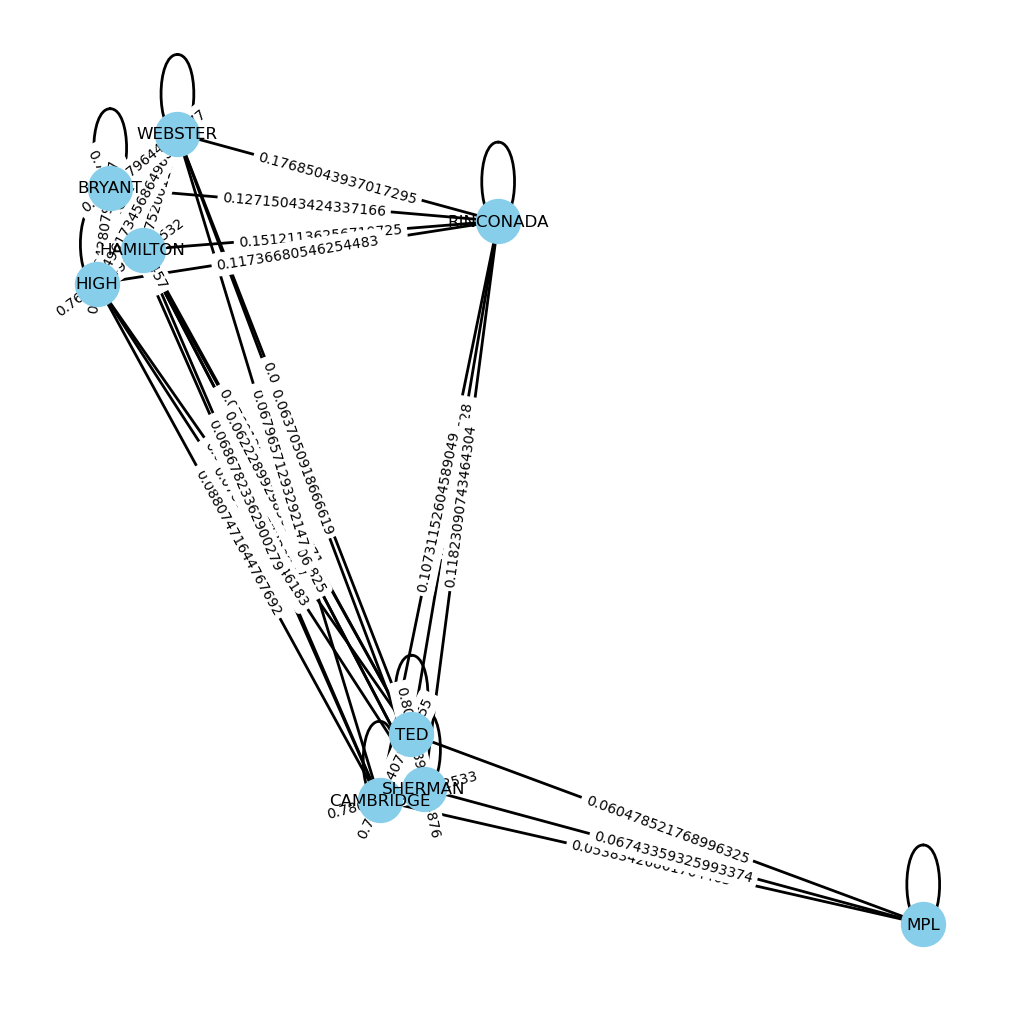

In [6]:
# plot graph
import matplotlib.pyplot as plt
import networkx as nx
# Plot graph with edge weights
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', edge_cmap=plt.cm.Blues, width=2)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [7]:
dist_matrix

,HAMILTON,HIGH,BRYANT,MPL,RINCONADA,WEBSTER,TED,CAMBRIDGE
0,0.000000,0.274261,0.286548,4.835102,1.889077,0.467204,2.290382,2.392885
1,0.274261,0.000000,0.361423,4.984757,2.142451,0.700830,2.359385,2.429570
2,0.286548,0.361423,0.000000,5.102025,2.062384,0.409311,2.576844,2.678323
3,4.835102,4.984757,5.102025,0.000000,3.441509,4.920413,2.805467,2.921845
4,1.889077,2.142451,2.062384,3.441509,0.000000,1.732451,1.952254,2.232019
5,0.467204,0.700830,0.409311,4.920413,1.732451,0.000000,2.545045,2.688752
6,2.290382,2.359385,2.576844,2.805467,1.952254,2.545045,0.000000,0.297185
7,2.392885,2.429570,2.678323,2.921845,2.232019,2.688752,0.297185,0.000000


In [8]:
from torch_geometric_temporal.nn.recurrent import TGCN

In [9]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()
print(np.array(loader.features).shape)
print("snapshots:", len(loader.features))
print("nodes:", len(np.unique(loader._edges[0])))
print("lags:", np.array(loader.features).shape[2])

(517, 20, 4)
snapshots: 517
nodes: 20
lags: 4


In [10]:
np.array(loader.features)[0]

array([[-1.08135724e-03,  2.85705967e-02,  3.54742090e-01,
         2.95438182e-01],
       [-7.11136085e-01, -5.98430173e-01,  1.90511208e-01,
         1.09215850e+00],
       [-3.22808515e+00, -2.29097341e-01,  1.61028185e+00,
        -1.54865198e+00],
       [ 6.47498206e-01, -2.21172216e+00, -9.68582871e-01,
         1.18619190e+00],
       [-1.73017563e-01, -9.47168633e-01,  1.03465811e+00,
        -6.37508205e-01],
       [ 3.63451633e-01, -7.54676576e-01,  2.97679386e-01,
        -1.62726348e-01],
       [-3.41740820e+00,  1.70305485e+00, -1.64338950e+00,
         1.74337346e+00],
       [-1.96411246e+00,  5.52076484e-01,  1.18112372e+00,
         6.70022840e-01],
       [-2.21326374e+00,  3.04922302e+00, -2.38393899e+00,
         1.85449629e+00],
       [-3.31407134e-01,  9.52179585e-01, -3.72813157e-01,
        -8.29709946e-02],
       [-1.83795542e+00, -5.87281544e-01, -3.55136591e-02,
        -7.22981848e-02],
       [-3.46685576e-01, -1.98268825e-01,  3.95398175e-01,
      

In [11]:
from torch_geometric.utils.convert import from_networkx
data = from_networkx(G)
data

Data(edge_index=[2, 71], pos=[9, 2], ID=[9], lat=[9], long=[9], weight=[71])

In [12]:
from torch_geometric_temporal.signal import temporal_signal_split


In [13]:
df_sess = pd.read_csv('../data/charging_session_count_30.csv', parse_dates=['Period'])
df_sess

,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
0,2011-07-29 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2011-07-29 20:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2011-07-29 21:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2011-07-29 21:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2011-07-29 22:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
156657,2020-07-05 12:30:00,0.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0
156658,2020-07-05 13:00:00,0.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
156659,2020-07-05 13:30:00,0.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0
156660,2020-07-05 14:00:00,0.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0


In [14]:
def get_targets_and_features(self, lags=4, add_month=True, add_week=True, add_day_of_week=True):
    stacked_target = np.array(df_sess.drop(['Period'], axis=1))

    # Get initial lagged features
    features = np.array([
        stacked_target[i : i + lags, :].T
        for i in range(stacked_target.shape[0] - lags)
    ])
    targets = np.array([
        stacked_target[i + lags, :].T
        for i in range(stacked_target.shape[0] - lags)
    ])

    # The `feat` matrix will go from (time_length, nodes, lags) to (time_length, nodes, lags+number of extra features)
    # We repeat the date-specific features 8 times because we have 8 nodes.
    if add_month:
        features = np.concatenate((features, df_sess.Period.dt.month.values.reshape(-1, 1,1)[lags:].repeat(8, axis=1)), axis=2) 
    if add_day_of_week:
        features = np.concatenate((features, df_sess.Period.dt.dayofweek.values.reshape(-1, 1,1)[lags:].repeat(8, axis=1)), axis=2)
    if add_week:
        # This one has a weird pandas.arrays.IntegerArray type, so we need to convert it to a numpy array
        features = np.concatenate((features, df_sess.Period.dt.isocalendar().week.to_numpy(dtype=int).reshape(-1, 1,1)[lags:].repeat(8, axis=1)), axis=2)

    return features, targets

In [15]:
feats, targets = get_targets_and_features(df_sess, lags=4, add_month=True, add_day_of_week=True, add_week=True)
time_length, nodes, feature_num = feats.shape
print(f"Time length: {time_length}, Nodes: {nodes}, Features: {feature_num}")

Time length: 156658, Nodes: 8, Features: 7


In [16]:
df_sess.Period.dt.isocalendar().week.to_numpy(dtype=int)

array([30, 30, 30, ..., 27, 27, 27])

In [17]:
from torch_geometric_temporal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

dataset = StaticGraphTemporalSignal(
        data.edge_index, data.edge_stores[0]['weight'].float(), feats, targets
    )
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [19]:
model = RecurrentGCN(node_features = feature_num)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in range(5):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    print(f"Epoch {epoch}, cost {cost.item()}")
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

Epoch 0, cost 0.7196112275123596
Epoch 1, cost 0.5841534733772278
Epoch 2, cost 0.5631146430969238


In [ ]:
feats

array([[[0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [1.0, 1.0, 1.0, ..., 7.0, 4.0, 30],
        ...,
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30]],

       [[0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [1.0, 1.0, 1.0, ..., 7.0, 4.0, 30],
        ...,
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30]],

       [[0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [1.0, 1.0, 1.0, ..., 7.0, 4.0, 30],
        ...,
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30],
        [0.0, 0.0, 0.0, ..., 7.0, 4.0, 30]],

       ...,

       [[0.0, 0.0, 0.0, ..., 7.0, 6.0, 27],
        [10.0, 10.0, 9.0, ..., 7.0, 6.0, 27],
        [0.0, 0.0, 0.0, ..., 7.0, 6.0, 27],
        ...,
   